In [1]:
##This file is used to test code.
##The test data based on current csv files which is updated till now, for further test please follow the assets given by interation part.

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


Congratulations! Legal Input!
--------------------------------------------------------------------------

Now, please type in your views towards assets in your selection set.

There are two kinds of views you could input: Absolute views & Relative views.

In this part, we only ask you to input your absolute views. 

To express your absolute views, you could type in views in formats as follows: 

'AMZN 0.05', which means that the asset 'Amazon' could achieve the rate of return at (5%+rf).

Here, 5% is the excess rate of return compared with risk-free rate.

(Attention please: the excess rate of return should be positive)

Please type in your absolute views towards assets:

(Please use decimal numbers to reflect the return, e.g. 0.03 stands for 3% in rate of return)

(one single example:'AMZN, 0.05; CVX, 0.03')

(If you do not hold any absolute views, just press enter.)
---------------------

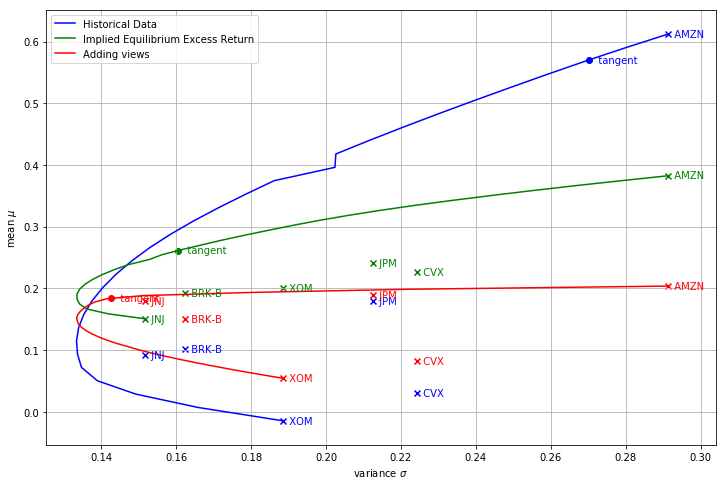

,CVX,AMZN,XOM,JNJ,JPM,BRK-B
Return,3.048012e-02,0.612272,-1.437333e-02,9.234222e-02,0.179262,0.102259
Weight (Markowitz opt),3.932014e-17,0.903448,1.664850e-17,8.067035e-18,0.096552,0.000000
Weight (Reverse Optimization),9.199404e-02,0.336225,1.370866e-01,1.614822e-01,0.150648,0.122564
Weight (Blacklitterman opt),2.213661e-17,0.131313,3.760183e-18,6.708610e-01,0.197826,0.000000


,Portfolio(add risk_free) Return,Portfolio(add risk_free) Volitality
Markowitz Model,0.570464,0.073081
Reverse Model,0.261306,0.025721
Blacklitterman Model(SCLALAR=0.025),0.184835,0.020369


,CVX,AMZN,XOM,JNJ,JPM,BRK-B
CVX,0.050319,0.015214,0.032125,0.012299,0.023902,0.018954
AMZN,0.015214,0.084940,0.013196,0.011489,0.019092,0.015340
XOM,0.032125,0.013196,0.035516,0.012261,0.020120,0.017128
JNJ,0.012299,0.011489,0.012261,0.023037,0.014140,0.013580
JPM,0.023902,0.019092,0.020120,0.014140,0.045156,0.025969
BRK-B,0.018954,0.015340,0.017128,0.013580,0.025969,0.026399


In [2]:
%pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 8)
import scipy.optimize
from numpy import *
from pandas import *
import re

from datetime import datetime
######################### Have to install pandas-datareader on terminal first!!! ######################
# terminal: conda install -c anaconda pandas-datareader 
# or $ pip install pandas-datareader
import pandas_datareader as pdr


#####################################################################################################################
##At the beginning of the project, we need to ask users to provide the assets they would like to invest

## Note here we put the 'SymbolsAndCaps.csv' under the folder named 'data', you can find it in
## our github project. To ensure the program can be be excuted successfully, you MUST put the python file 
## and 'data' folder under the same folder.
base = 'data/'
pool_file = base + 'SymbolsAndCaps.csv'    
    
# Function loads stocks symbols and their market capitalizations, as of Nov 29, 2018
def load_symbols_and_caps(file):
    symbols_caps = pandas.read_csv(file, index_col = None) # symbols_caps is a pandas.dataframe
    symbols_caps.dropna(how = "all", inplace = True)
    symbols = list(symbols_caps['symbols'])
    caps = list(symbols_caps['caps'])
    return symbols, caps

# Function takes in user input and returns a list of stock symbols if input is legal and returns [] otherwise
def select_assets(*args):
    pool_symbols, _ = load_symbols_and_caps(pool_file)
    try:
        assets = ''.join(args).upper().split(' ')
    except:
        print('\n\nWarning: Illegal input!\n\n')
        return []
    if set(pool_symbols).union(set(assets)) != set(pool_symbols):
        print('\n\nWarning: Illegal input format or stock not in our pool! Please type again!\n\n')
        return []
    else:
        print('\n\nCongratulations! Legal Input!')
        return assets

assets_list = []
while assets_list == []:
    assets_list = input('''-----------------------------------------------------\n
    Welcome to use the Blacklitterman Model project. \nBased on the performance, we provide 20 assets that are worthy of investing. \nThe symbols of these 20 assets are as follows: \n\nAAPL MSFT AMZN JNJ GOOG JPM XOM FB GOOGL BRK-B \nWMT BAC UNH PFE WFC V VZ PG CVX T
    \nPlease type in the stock symbols you are interested in and separate them with a white space. Press Enter to complete. For example, AMZN AAPL BRK-B\n\n''')
    assets_list = select_assets(assets_list)    
#####################################################################################################################

# Function extract market caps corresponding to the stock symbols entered by the user
# and also loads the historical stock prices and returns stock symbols, caps and historical prices
def load_data(assets_list):
    
    pool_symbols, pool_caps = load_symbols_and_caps(pool_file) # first load all symbols and caps in the pool
    
    symbols = list(set(assets_list)) # remove repeated symbols
    caps = [] # extract market caps of the stocks chosen by the user
    for s in symbols:
        caps.append(pool_caps[pool_symbols.index(s)])
    
    price_arrays = [] # array of close prices of each stock chosen by the user
    for s in symbols:
        data = pandas.read_csv('data/%s.csv' % s, index_col=None, parse_dates=True) # data is a pandas.dataframe
        prices = list(data['Close'])
        price_arrays.append(prices) 
    return symbols, caps, price_arrays # price_arrays is an n*T list    

# We get symbols caps, price_arrays from the load_data function for later use.
symbols, caps, price_arrays = load_data(assets_list)

#Functions get market capitilizaions from our chosen data
#and use these data to calculate weights, return and covariance
def compute_some_statistics(price_arrays):
    #Transfer a list of prices into a matrix
    price_up = numpy.mat(price_arrays)
    #Use our data to compute daily return
    price_row = numpy.size(price_up, 0)
    price_col = numpy.size(price_up, 1)
    data_return = numpy.zeros([price_row, price_col - 1])
    for i in range(price_row):
        for j in range(price_col - 1):
            p_start = price_up[i, j]
            p_end = price_up[i, j + 1]
            data_return[i, j] = (p_end - p_start)/ p_start      
    cal_return = numpy.array([])
    for i in range(price_row):
        mean_return = numpy.mean(data_return[i])
        cal_return = numpy.append(cal_return, mean_return)
    #Use our data to compute daily var_cov matrix  
    var_cov_matx = cov(data_return)
    #We assume that there are 250 tarding days in one year, and calculate annulized return
    #and annulized var_cov matrix
    cal_return = (1 + cal_return) ** 250 - 1
    var_cov_matx  = var_cov_matx * 250
    return cal_return, var_cov_matx

#Calculate weight from market caps
#Calculate return and var_cov_matrix
W = np.array(caps) / sum(caps)
Rp, Vp= compute_some_statistics(price_arrays)
#In practice, this 1.5% real risk-free rate is the rate that investors expect to earn after 
#inflation from a risk-free investment with a 10-year duration after inflation.
rf = 0.015
#####################################################################################################################

###Also, we need to ask investors to obtain their views towards the assets they invest.
##Firstly, absolute views

print('''--------------------------------------------------------------------------\n
Now, please type in your views towards assets in your selection set.\n
There are two kinds of views you could input: Absolute views & Relative views.\n
In this part, we only ask you to input your absolute views. \n
To express your absolute views, you could type in views in formats as follows: \n
'AMZN 0.05', which means that the asset 'Amazon' could achieve the rate of return at (5%+rf).\n
Here, 5% is the excess rate of return compared with risk-free rate.\n
(Attention please: the excess rate of return should be positive)\n
Please type in your absolute views towards assets:\n
(Please use decimal numbers to reflect the return, e.g. 0.03 stands for 3% in rate of return)\n
(one single example:'AMZN, 0.05; CVX, 0.03')\n
(If you do not hold any absolute views, just press enter.)''')
view = {'absolute':[],'relative':[]}
abso_view_judge = 1
while abso_view_judge:
    abso_view_judge = 0
    abso_view_ori = input()
    if not abso_view_ori:
        abso_view_ori = 0
        view['absolute'] = []
        break
    else:
        abso_pattern = r'[A-Za-z-]+\W*[0-9.-]+'
        user_abso_view_str = re.findall(abso_pattern,abso_view_ori)
        view = dict()
        abso_view_list = []
        for i in user_abso_view_str:
            abso_name = r'^[A-Za-z-]+'
            abso_excess_return = r'[0-9.-]+$'
            temp_name = re.findall(abso_name,i)
            temp_ret = re.findall(abso_excess_return,i)
            name_judge = 0
            for j in symbols:
                if j == temp_name[0]:
                    name_judge += 1
            if name_judge > 0 and float(temp_ret[0]) > 0:
                abso_view_list.append([temp_name[0],'',temp_ret[0]])
            elif name_judge == 0:
                print('Please input view about assets that you want to invest!\nPlease input your view again!')
                abso_view_judge = 1
                continue
            elif float(temp_ret[0]) <= 0:
                print('Attention please: the excess return should be positive!\nPlease input your view again!')
                abso_view_judge = 1
                continue
        view['absolute'] = abso_view_list

#check the view input
view
################################################################################################

###Ask for relative views

print('''----------------------------------------------------------------------------------\n
Now, please type in your relative views towards assets in your selection set.\n
This kind of view should claim relationship between two different assets in your selection set.\n
To input your relative views, you should compare the return of two chosen assets\n
using specific patterns as follows(should include > or <): 'AMZN > CVX 0.03',\n
which means that you think that the asset 'AMZN' will have a higher return\n
compared with 'CVX', and the difference between them should be 3%(=0.03).\n
So, a valid example could be: 'AMZN > CVX 0.03;AAPL < JPM 0.02'\n
(Attention please: the difference here should be positive, for you can input < or >)''')

relat_view_judge = 1
while relat_view_judge:
    relat_view_judge = 0
    relat_view_ori = input()
    if not relat_view_ori:
        relat_view_judge = 0
        view['relative'] = []
        break
    else:
        relat_pattern = r'[A-Za-z-]+\W*[<>]\W*[A-Za-z-]+\W*[0-9.-]+'
        user_relat_view_str = re.findall(relat_pattern,relat_view_ori)
        if not user_relat_view_str:
                print('Please input valid relative views!\nPlease input again:')
                relat_view_judge = 1
                continue
        relat_view_list = []
        for i in user_relat_view_str:
            relat_both_name = r'^[A-Za-z-]+\W*[<>]\W*[A-Za-z-]+'
            relat_excess_return = r'[0-9.-]+$'
            temp_both_name = re.findall(relat_both_name,i)
            temp_ret = re.findall(relat_excess_return,i)
            smaller = 0
            for k in i:
                if k == '<':
                    smaller = 1
            relat_name1 = r'^[A-Za-z-]+'
            relat_name2 = r'[A-Za-z-]+$'
            temp_name1 = re.findall(relat_name1,temp_both_name[0])
            temp_name2 = re.findall(relat_name2,temp_both_name[0])
            name1 = temp_name1[0]
            name2 = temp_name2[0]
            if name1 == name2:
                print('Cannot compare two assets that are the same.')
                relat_view_judge = 1
                continue
            if smaller == 1:
                temp = name1
                name1 = name2
                name2 = temp
            name_judge = 0
            for j in symbols:
                if j == name1 or j == name2:
                    name_judge += 1
            if name_judge == 2 and float(temp_ret[0]) > 0:
                relat_view_list.append([name1,name2,temp_ret[0]])#adjust the sequence to make name1 > name2
            elif name_judge < 2:
                print('Please input view about assets that you want to invest!\nPlease input your view again!')
                relat_view_judge = 1
                continue
            elif float(temp_ret[0]) <= 0:
                print('Attention please: the excess return should be positive!\nPlease input your view again!')
                relat_view_judge = 1
                continue
        view['relative'] = relat_view_list
#check the view input
view
###################################################################################

##This part of function is to created the view matrix and link matrix according to input of users views
def matrix_view_and_link(symbols,view):
    #set view matrix
    view_=[]
    for i in view:
        for j in view[i]:
            view_.append(j)                
    view_matrix = [view_[i][2] for i in range(len(view_))]
    view_matrix =array([float(i) for i in view_matrix])
    
    #set an empty view link matrix 
    p_count = len(symbols)
    view_count = len(view_matrix)
    link_matrix= zeros([view_count,p_count]) 
    
    #refill the link matrix according to the view matrix
    i = 0
    symbols_index = dict()
    for asset in symbols:
        symbols_index[asset] = i
        i +=1
    for i in range(len(view_)):
        symbol_1=view_[i][0]
        symbol_2=view_[i][1]
        link_matrix[i,symbols_index[symbol_1]] = 1
        #recognize the absolute views and relative views
        if symbol_2:
            link_matrix[i,symbols_index[symbol_2]] = -1
          
    return view_matrix, link_matrix

##Compute the view_matix and link_matrix from our user input 
# for later use
view_matrix, link_matrix = matrix_view_and_link(symbols, view)

###############################################################################################

##The function to calculate the valid frontier of portfolio constructed with given assets##
def frontier_of_portfolio(Rp, Vp, rf):
    exp_mean = []
    opt_var = []
    
    num_of_assets = len(Rp)
    
    min_ret = min(Rp)
    max_ret = max(Rp)
    group = 30 #Calculate 30 groups of optimal solution
    interval = (max_ret - min_ret)/(group - 1)
    ret_list = []
    for i in range(group):
        ret_list.append((min_ret + interval * i))
    # For given level of return r, find weights which minimizes portfolio variance.  
    def func_for_optimization(Wp, Rp, Vp, r):
        mean = dot(Wp, Rp)
        var = dot(dot(Wp, Vp), Wp)
        penalty = 100 * abs(mean - r)
        #To guarantee that the mean of return of the portfolio should equal to r
        return var + penalty
    for r in ret_list:#The recursion should follows different target return
        Wp = ones(num_of_assets) / num_of_assets #The initial weight for optimization
        boundary = [] 
        for i in range(num_of_assets):
            boundary.append((0, 1))
            #The boundary of each weight for a specific asset
        constraint_ = ({'type': 'eq', 'fun': lambda Wp: sum(Wp) - 1.0})
        #The constraints in optimizing that the sum of weights should equal to 1
        opt_result = scipy.optimize.minimize(
            func_for_optimization, Wp, (Rp, Vp, r), method = 'SLSQP',
            constraints = constraint_, bounds = boundary)
        
        if opt_result.success:
            exp_mean.append(r)
            opt_var.append(dot(dot(opt_result.x, Vp), opt_result.x))
        else:
            raise BaseException(opt_result.message)
    
    return array(exp_mean), array(opt_var)
###############################################################################################

##This function is used to calculate tangent point based on optimal portfolio and risk-free rate
def weight_MV(Rp, Vp, rf):
    def weight_initial(Rp):                 # initial weight of the optimization procedure
        port_count = len(Rp)
        Wp=[]
        for i in range(port_count):
            Wp.append(1 / port_count)         # set all of these assets with equal weights in the portfolio
        return Wp
    def MV_object_function(Wp, Rp, Vp, rf):    # return the objective function of MV_optimization $$$$$$$$change 
        p_mean = sum(Rp * Wp)                 #calculate the mean return of the portfolio
        p_var = dot(dot(Wp , Vp), Wp)          #calculate the variance of the portfolio
        p_sharp_ratio= (p_mean - rf) / sqrt(p_var)
        object_func =  1 / p_sharp_ratio
        return object_func
    def MV_optimal(Rp, Vp, rf):
        Wp = weight_initial(Rp)              # input the initial weight
        bound = []                           # add each bound of every assets weight in the spread from [0,1]
        for i in range(len(Rp)):
            bound.append((0., 1.))                 
        constraint = ({'type': 'eq',         # give the constraints of optimization problem, the sum of weight equals to 1.0
                          'fun': lambda Wp: sum(Wp) - 1.}) 
        weight_optimal =scipy.optimize.minimize(MV_object_function, 
                                                Wp,(Rp, Vp, rf), method='SLSQP', constraints=constraint, bounds=bound)
                                             #calculate the optimal weight of each assests in the portfolio in MV model
        if weight_optimal.success:
            return weight_optimal.x
        else:
            raise BaseException(weight_optimal.message)
    return MV_optimal(Rp, Vp, rf)
#####################################################################################################################

##This part is used to optimize the portfolio based on equilibrium excess return##
def optimal_portfolio_based_on_equilibrium_returns(Rp,Vp,rf):
    Wp = weight_MV(Rp,Vp,rf)
    opt_mean = dot(Wp,Rp)
    opt_var = dot(dot(Wp,Vp),Wp)
    frontier_mean,frontier_var = frontier_of_portfolio(Rp,Vp,rf)
    result_implied_return = dict()
    result_implied_return['Weights']=Wp
    result_implied_return['Tangent_mean']=opt_mean
    result_implied_return['Tangent_var']=opt_var
    result_implied_return['Frontier_mean']=frontier_mean
    result_implied_return['Frontier_var']=frontier_var
    return result_implied_return

##W is the market capitalization weights
def equilibrium_excess_return(W,Rp,Vp):
    mean = dot(W,Rp)
    var = dot(dot(W,Vp),W)
    lamuda = (mean - rf)/var
    return dot(dot(lamuda,Vp),W)

Pi = equilibrium_excess_return(W,Rp,Vp)##Using market capitalization weight W

result_eq = optimal_portfolio_based_on_equilibrium_returns(Pi+rf,Vp,rf)

###############################################################################################

## This part is used to optimize the portfolio based on equilibrium excess return 
## after adding investers' views and relation matrix into the equilibrium excess return--"Pi"
def optimization_adding_views(Vp,view,view_link,Pi,rf):

    def pi_add_view(Vp,view,view_link,Pi):  
        
        # This is a scalar number indicating the uncertainty of the CAPM distribution (0.025-0.05)
        # Scalar too high makes a very weak statement for our prior estimate of the mean.
        # Here we set it equals to 0.025 according to Lee's paper.
        scalar = 0.025       
        ##weight is measured by uncertainty, this is the uncertainty matrix of equilibrium excess return: pi_vol (n*n matrix)
        pi_vol = dot(scalar,Vp)                    
        view_vol= dot(dot(dot(scalar,view_link),Vp),transpose(view_link))  
        pi_vol_inv = inv(pi_vol)                
        view_vol_inv = dot(dot(transpose(view_link),inv(view_vol)),view_link) 
        pi_view_weighted =dot(pi_vol_inv,Pi)+dot(dot(transpose(view_link),inv(view_vol)),view) 
        pi_new= dot(inv(view_vol_inv +pi_vol_inv), pi_view_weighted)  
        ##the new equilibrium return weighted by the inverse of uncertainty and standardization
    
        return pi_new                          

    # get the optimal allocation weights and efficent frontier based on new equilibrium excess return
    pi_new = pi_add_view(Vp,view,view_link,Pi)   
    Wp_new = weight_MV(pi_new+rf,Vp,rf)
    mean_new = sum(Wp_new * (pi_new+rf))
    var_new = dot(dot(Wp_new,Vp),Wp_new)
    mean_frontier, var_frontier = frontier_of_portfolio(pi_new+rf,Vp,rf)
    
    result_adding_views= dict()
    result_adding_views['Pi']=pi_new
    result_adding_views['Weights']=Wp_new
    result_adding_views['Tangent_mean']=mean_new
    result_adding_views['Tangent_var']=var_new
    result_adding_views['Frontier_mean']=mean_frontier
    result_adding_views['Frontier_var']=var_frontier
    return result_adding_views
  
######################################################################################################

##This function is used to draw efficient frontier of given assets
def graph_efficient_frontier(optimal,label=None, color='black'):
    text(optimal['Tangent_var'] ** .5, optimal['Tangent_mean'], '   tangent', verticalalignment='center', color=color)
    scatter(optimal['Tangent_var'] ** .5, optimal['Tangent_mean'], marker='o', color=color), grid(True)
    plot(optimal['Frontier_var'] ** .5, optimal['Frontier_mean'], label=label, color=color), grid(True) 
    
##This function is used to add nodes pof assets and mark labels to each nodes in the graph
def graph_names(names, Rp, Vp, color='black'):
    scatter([Vp[i, i] ** .5 for i in range(len(Rp))], Rp, marker='x', color=color), grid(True)  
    for i in range(len(Rp)): 
        text(Vp[i, i] ** .5, Rp[i], '  %s' % names[i], verticalalignment='center', color=color) 


##################################################################################################
##Collect the optimal weight of 3 models
optimal_historical_data = optimal_portfolio_based_on_equilibrium_returns(Rp,Vp,rf)
optimal_implied_excess_return =optimal_portfolio_based_on_equilibrium_returns(Pi+rf,Vp,rf)
optimal_adding_views = optimization_adding_views(Vp,view_matrix,link_matrix,Pi,rf)

## Display the whole model reslut using and tables graphs:
def OUTPUT_MODEL(optimal_historical_data,optimal_implied_excess_return,optimal_adding_views):
    #Graph based on comparison among three models
    graph_names(symbols,Rp,Vp,color='blue')
    graph_efficient_frontier(optimal_historical_data,label='Historical Data', color='blue')

    graph_names(symbols, Pi+rf, Vp, color='green')
    graph_efficient_frontier(optimal_implied_excess_return,label='Implied Equilibrium Excess Return', color='green')

    graph_names(symbols,optimal_adding_views['Pi']+rf, Vp, color='red')
    graph_efficient_frontier(optimal_adding_views,label='Adding views', color='red')

    xlabel('variance $\sigma$'), ylabel('mean $\mu$'), legend(), show()
    
    #This part will output a table to tell the users their optimal weights 
    #on their selecting assets based on three given models:
    display(pandas.DataFrame({'Return': Rp, 'Weight (Markowitz opt)': weight_MV(Rp,Vp,rf),
                          'Weight (Reverse Optimization)': optimal_portfolio_based_on_equilibrium_returns(Pi+rf,Vp,rf)['Weights'],
                          'Weight (Blacklitterman opt)': optimal_adding_views['Weights']}, index=symbols).T)
    #This part will output a table to tell the users their optimal return and volitality
    #on their selecting assets and risk free assets based on three given models:
    display(pandas.DataFrame({'Markowitz Model':[optimal_historical_data['Tangent_mean'],optimal_historical_data['Tangent_var']],
                          'Reverse Model': [optimal_implied_excess_return['Tangent_mean'],optimal_implied_excess_return['Tangent_var']],
                          'Blacklitterman Model(SCLALAR=0.025)': [optimal_adding_views['Tangent_mean'],optimal_adding_views['Tangent_var']]}, 
                         index=['Portfolio(add risk_free) Return','Portfolio(add risk_free) Volitality']).T)
    #Display the var_cov_matrix of the assets chosen by users.
    display(pandas.DataFrame(Vp, columns=symbols, index=symbols))

 ######################################################################################################

OUTPUT_MODEL(optimal_historical_data,optimal_implied_excess_return,optimal_adding_views)

In [ ]:
##The code below this cell is used for testing
##Because this project contains code for interaction to customize portfolio based on views,
##we test the code using different inputs given by us. 
##Also, this project is constructed based on mathematical model, which means this program is used for calculation.
##In this way, we will not use the keyword assert to test our project.
##Instead, we test it with different data.

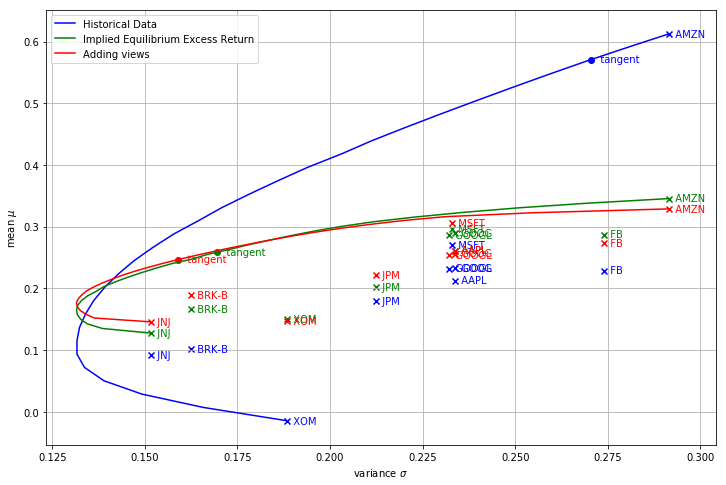

,AMZN,XOM,JNJ,GOOG,JPM,GOOGL,AAPL,FB,MSFT,BRK-B
Return,0.612272,-1.437333e-02,0.092342,2.331631e-01,0.179262,2.322172e-01,0.212749,2.288270e-01,2.699550e-01,0.102259
Weight (Markowitz opt),0.904249,4.380177e-17,0.000000,0.000000e+00,0.095751,0.000000e+00,0.000000,1.040834e-17,1.994932e-17,0.000000
Weight (Reverse Optimization),0.165387,6.702987e-02,0.078873,7.283226e-02,0.073858,6.922680e-02,0.173096,6.635730e-02,1.729757e-01,0.060364
Weight (Blacklitterman opt),0.147151,1.219727e-18,0.152224,2.425902e-18,0.065780,1.941400e-18,0.157796,5.613029e-02,2.170198e-01,0.203899


,Portfolio(add risk_free) Return,Portfolio(add risk_free) Volitality
Markowitz Model,0.570811,0.073172
Reverse Model,0.258775,0.028693
Blacklitterman Model(SCLALAR=0.025),0.246705,0.025243


,AMZN,XOM,JNJ,GOOG,JPM,GOOGL,AAPL,FB,MSFT,BRK-B
AMZN,0.084940,0.013196,0.011489,0.042544,0.019092,0.042082,0.029005,0.043298,0.039459,0.015340
XOM,0.013196,0.035516,0.012261,0.013562,0.020120,0.013530,0.013809,0.012798,0.015566,0.017128
JNJ,0.011489,0.012261,0.023037,0.012915,0.014140,0.012905,0.010421,0.011435,0.014160,0.013580
GOOG,0.042544,0.013562,0.012915,0.054630,0.019649,0.053738,0.026361,0.038071,0.035502,0.017091
JPM,0.019092,0.020120,0.014140,0.019649,0.045156,0.019360,0.019708,0.019539,0.023346,0.025969
GOOGL,0.042082,0.013530,0.012905,0.053738,0.019360,0.053889,0.026103,0.038124,0.034565,0.016909
AAPL,0.029005,0.013809,0.010421,0.026361,0.019708,0.026103,0.054600,0.027952,0.028913,0.015849
FB,0.043298,0.012798,0.011435,0.038071,0.019539,0.038124,0.027952,0.075037,0.031971,0.015367
MSFT,0.039459,0.015566,0.014160,0.035502,0.023346,0.034565,0.028913,0.031971,0.054308,0.019610
BRK-B,0.015340,0.017128,0.013580,0.017091,0.025969,0.016909,0.015849,0.015367,0.019610,0.026399


In [3]:
##BEGIN TEST
##For user's input:(three parts)
## AAPL MSFT AMZN JNJ GOOG JPM XOM FB GOOGL BRK-B
## MSFT 0.3
## JNJ > XOM 0.02,BRK-B < GOOG 0.01
assets_list = ['AAPL','MSFT','AMZN','JNJ','GOOG','JPM','XOM','FB','GOOGL','BRK-B']
view = {'absolute':[['MSFT','', 0.3]],'relative':[['JNJ','XOM',0.02],['GOOG','BRK-B',0.01]]}
symbols, caps, price_arrays = load_data(assets_list)
compute_some_statistics(price_arrays)
W = np.array(caps) / sum(caps)
Rp, Vp= compute_some_statistics(price_arrays)
view_matrix, link_matrix = matrix_view_and_link(symbols, view)
Pi = equilibrium_excess_return(W,Rp,Vp)
result_eq = optimal_portfolio_based_on_equilibrium_returns(Pi+rf,Vp,rf)
optimal_historical_data = optimal_portfolio_based_on_equilibrium_returns(Rp,Vp,rf)
optimal_implied_excess_return =optimal_portfolio_based_on_equilibrium_returns(Pi+rf,Vp,rf)
optimal_adding_views = optimization_adding_views(Vp,view_matrix,link_matrix,Pi,rf)
OUTPUT_MODEL(optimal_historical_data,optimal_implied_excess_return,optimal_adding_views)
##END TEST

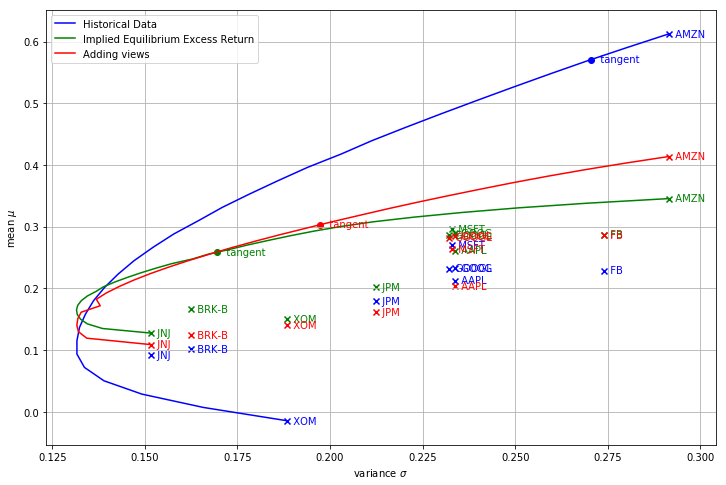

,AMZN,XOM,JNJ,GOOG,JPM,GOOGL,AAPL,FB,MSFT,BRK-B
Return,0.612272,-1.437333e-02,0.092342,0.233163,0.179262,0.232217,0.212749,2.288270e-01,2.699550e-01,0.102259
Weight (Markowitz opt),0.904249,4.380177e-17,0.000000,0.000000,0.095751,0.000000,0.000000,1.040834e-17,1.994932e-17,0.000000
Weight (Reverse Optimization),0.165387,6.702987e-02,0.078873,0.072832,0.073858,0.069227,0.173096,6.635730e-02,1.729757e-01,0.060364
Weight (Blacklitterman opt),0.438815,1.601606e-01,0.054457,0.078204,0.016532,0.076287,0.020887,7.715998e-02,7.749779e-02,0.000000


,Portfolio(add risk_free) Return,Portfolio(add risk_free) Volitality
Markowitz Model,0.570811,0.073172
Reverse Model,0.258775,0.028693
Blacklitterman Model(SCLALAR=0.025),0.303432,0.038973


,AMZN,XOM,JNJ,GOOG,JPM,GOOGL,AAPL,FB,MSFT,BRK-B
AMZN,0.084940,0.013196,0.011489,0.042544,0.019092,0.042082,0.029005,0.043298,0.039459,0.015340
XOM,0.013196,0.035516,0.012261,0.013562,0.020120,0.013530,0.013809,0.012798,0.015566,0.017128
JNJ,0.011489,0.012261,0.023037,0.012915,0.014140,0.012905,0.010421,0.011435,0.014160,0.013580
GOOG,0.042544,0.013562,0.012915,0.054630,0.019649,0.053738,0.026361,0.038071,0.035502,0.017091
JPM,0.019092,0.020120,0.014140,0.019649,0.045156,0.019360,0.019708,0.019539,0.023346,0.025969
GOOGL,0.042082,0.013530,0.012905,0.053738,0.019360,0.053889,0.026103,0.038124,0.034565,0.016909
AAPL,0.029005,0.013809,0.010421,0.026361,0.019708,0.026103,0.054600,0.027952,0.028913,0.015849
FB,0.043298,0.012798,0.011435,0.038071,0.019539,0.038124,0.027952,0.075037,0.031971,0.015367
MSFT,0.039459,0.015566,0.014160,0.035502,0.023346,0.034565,0.028913,0.031971,0.054308,0.019610
BRK-B,0.015340,0.017128,0.013580,0.017091,0.025969,0.016909,0.015849,0.015367,0.019610,0.026399


In [12]:
##BEGIN TEST
##For user's input:(three parts)
## AAPL MSFT AMZN JNJ GOOG JPM XOM FB GOOGL BRK-B
## AAPL 0.09
## MSFT > XOM 0.1, BRK-B < AMZN 0.4
assets_list = ['AAPL','MSFT','AMZN','JNJ','GOOG','JPM','XOM','FB','GOOGL','BRK-B']
view = {'absolute':[['AAPL','', 0.13]],'relative':[['MSFT','XOM',0.1],['AMZN','BRK-B',0.4]]}
symbols, caps, price_arrays = load_data(assets_list)
compute_some_statistics(price_arrays)
W = np.array(caps) / sum(caps)
Rp, Vp= compute_some_statistics(price_arrays)
view_matrix, link_matrix = matrix_view_and_link(symbols, view)
Pi = equilibrium_excess_return(W,Rp,Vp)
result_eq = optimal_portfolio_based_on_equilibrium_returns(Pi+rf,Vp,rf)
optimal_historical_data = optimal_portfolio_based_on_equilibrium_returns(Rp,Vp,rf)
optimal_implied_excess_return =optimal_portfolio_based_on_equilibrium_returns(Pi+rf,Vp,rf)
optimal_adding_views = optimization_adding_views(Vp,view_matrix,link_matrix,Pi,rf)
OUTPUT_MODEL(optimal_historical_data,optimal_implied_excess_return,optimal_adding_views)
##END TEST

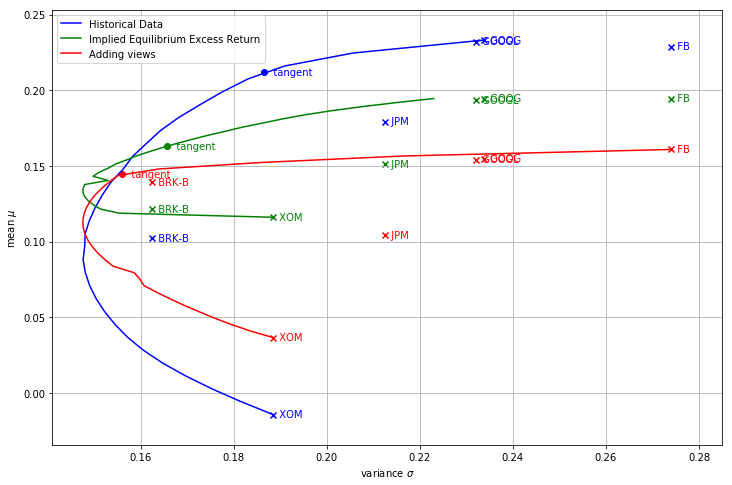

,XOM,GOOG,JPM,GOOGL,FB,BRK-B
Return,-1.437333e-02,0.233163,1.792624e-01,0.232217,0.228827,0.102259
Weight (Markowitz opt),0.000000e+00,0.131762,3.701595e-01,0.322436,0.175642,0.000000
Weight (Reverse Optimization),1.633264e-01,0.175627,1.817320e-01,0.171943,0.161811,0.145560
Weight (Blacklitterman opt),2.911357e-17,0.027854,1.189210e-16,0.142423,0.135517,0.694207


,Portfolio(add risk_free) Return,Portfolio(add risk_free) Volitality
Markowitz Model,0.212145,0.034778
Reverse Model,0.163002,0.027426
Blacklitterman Model(SCLALAR=0.025),0.144768,0.024317


,XOM,GOOG,JPM,GOOGL,FB,BRK-B
XOM,0.035516,0.013562,0.020120,0.013530,0.012798,0.017128
GOOG,0.013562,0.054630,0.019649,0.053738,0.038071,0.017091
JPM,0.020120,0.019649,0.045156,0.019360,0.019539,0.025969
GOOGL,0.013530,0.053738,0.019360,0.053889,0.038124,0.016909
FB,0.012798,0.038071,0.019539,0.038124,0.075037,0.015367
BRK-B,0.017128,0.017091,0.025969,0.016909,0.015367,0.026399


In [13]:
##BEGIN TEST
##For user's input:(three parts)
## GOOG JPM XOM FB GOOGL BRK-B
## GOOG 0.1
## XOM < BRK-B 0.2, JPM > XOM 0.1
assets_list = ['GOOG','JPM','XOM','FB','GOOGL','BRK-B']
view = {'absolute':[['GOOG','', 0.1]],'relative':[['BRK-B','XOM',0.2],['JPM','XOM',0.1]]}
symbols, caps, price_arrays = load_data(assets_list)
compute_some_statistics(price_arrays)
W = np.array(caps) / sum(caps)
Rp, Vp= compute_some_statistics(price_arrays)
view_matrix, link_matrix = matrix_view_and_link(symbols, view)
Pi = equilibrium_excess_return(W,Rp,Vp)
result_eq = optimal_portfolio_based_on_equilibrium_returns(Pi+rf,Vp,rf)
optimal_historical_data = optimal_portfolio_based_on_equilibrium_returns(Rp,Vp,rf)
optimal_implied_excess_return =optimal_portfolio_based_on_equilibrium_returns(Pi+rf,Vp,rf)
optimal_adding_views = optimization_adding_views(Vp,view_matrix,link_matrix,Pi,rf)
OUTPUT_MODEL(optimal_historical_data,optimal_implied_excess_return,optimal_adding_views)
##END TEST

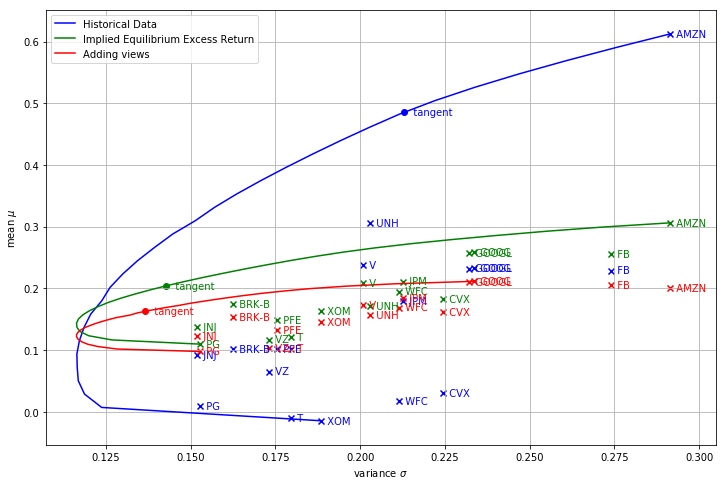

,UNH,AMZN,PG,CVX,WFC,XOM,JNJ,T,GOOG,JPM,GOOGL,VZ,FB,PFE,V,BRK-B
Return,0.305446,0.612272,0.009848,3.048012e-02,1.734379e-02,-1.437333e-02,0.092342,-1.064912e-02,2.331631e-01,0.179262,2.322172e-01,6.539978e-02,0.228827,0.101616,0.237521,1.022594e-01
Weight (Markowitz opt),0.413477,0.586523,0.000000,3.968206e-17,2.544739e-17,3.594874e-17,0.000000,1.062492e-17,1.319644e-17,0.000000,1.897354e-17,1.889382e-18,0.000000,0.000000,0.000000,1.040834e-17
Weight (Reverse Optimization),0.051674,0.157305,0.044713,4.362147e-02,4.966542e-02,6.346447e-02,0.075908,4.274882e-02,6.855136e-02,0.070182,6.697149e-02,4.734591e-02,0.063259,0.049793,0.047438,5.735935e-02
Weight (Blacklitterman opt),0.104620,0.015391,0.051703,5.071996e-02,3.522571e-02,7.439736e-02,0.088391,6.108236e-03,8.913738e-02,0.082464,9.132387e-02,5.574319e-02,0.073822,0.058295,0.055965,6.669339e-02


,Portfolio(add risk_free) Return,Portfolio(add risk_free) Volitality
Markowitz Model,0.485406,0.045352
Reverse Model,0.204399,0.020406
Blacklitterman Model(SCLALAR=0.025),0.162879,0.018621


,UNH,AMZN,PG,CVX,WFC,XOM,JNJ,T,GOOG,JPM,GOOGL,VZ,FB,PFE,V,BRK-B
UNH,0.041196,0.018738,0.008473,0.013084,0.017694,0.011774,0.012500,0.009814,0.017751,0.018864,0.017604,0.009396,0.016833,0.016957,0.017092,0.016309
AMZN,0.018738,0.084940,0.008701,0.015214,0.017272,0.013196,0.011489,0.008248,0.042544,0.019092,0.042082,0.006895,0.043298,0.012998,0.029683,0.015340
PG,0.008473,0.008701,0.023298,0.011277,0.008322,0.010671,0.010711,0.009764,0.009726,0.009722,0.009578,0.010801,0.008292,0.008471,0.010361,0.010767
CVX,0.013084,0.015214,0.011277,0.050319,0.019872,0.032125,0.012299,0.013189,0.014891,0.023902,0.014548,0.013196,0.016427,0.012165,0.016095,0.018954
WFC,0.017694,0.017272,0.008322,0.019872,0.044774,0.018220,0.012846,0.011865,0.017920,0.036459,0.017555,0.011338,0.016265,0.016472,0.019669,0.023963
XOM,0.011774,0.013196,0.010671,0.032125,0.018220,0.035516,0.012261,0.011776,0.013562,0.020120,0.013530,0.010865,0.012798,0.012121,0.014139,0.017128
JNJ,0.012500,0.011489,0.010711,0.012299,0.012846,0.012261,0.023037,0.010352,0.012915,0.014140,0.012905,0.011007,0.011435,0.014385,0.012862,0.013580
T,0.009814,0.008248,0.009764,0.013189,0.011865,0.011776,0.010352,0.032249,0.009398,0.012211,0.009383,0.021227,0.006781,0.009524,0.008525,0.012794
GOOG,0.017751,0.042544,0.009726,0.014891,0.017920,0.013562,0.012915,0.009398,0.054630,0.019649,0.053738,0.008292,0.038071,0.014381,0.026631,0.017091
JPM,0.018864,0.019092,0.009722,0.023902,0.036459,0.020120,0.014140,0.012211,0.019649,0.045156,0.019360,0.011810,0.019539,0.016557,0.021997,0.025969


In [14]:
##BEGIN TEST
##For user's input:(three parts)
## AMZN JNJ GOOG JPM XOM FB GOOGL BRK-B UNH PFE WFC V VZ PG CVX T
## AMZN 0.09
## UNH > T 0.06, WFC < GOOGL 0.02
assets_list = ['AMZN','JNJ','GOOG','JPM','XOM','FB','GOOGL','BRK-B','UNH','PFE','WFC','V','VZ','PG','CVX','T']
view = {'absolute':[['AMZN','', 0.08]],'relative':[['UNH','T',0.06],['GOOGL','WFC',0.02]]}
symbols, caps, price_arrays = load_data(assets_list)
compute_some_statistics(price_arrays)
W = np.array(caps) / sum(caps)
Rp, Vp= compute_some_statistics(price_arrays)
view_matrix, link_matrix = matrix_view_and_link(symbols, view)
Pi = equilibrium_excess_return(W,Rp,Vp)
result_eq = optimal_portfolio_based_on_equilibrium_returns(Pi+rf,Vp,rf)
optimal_historical_data = optimal_portfolio_based_on_equilibrium_returns(Rp,Vp,rf)
optimal_implied_excess_return =optimal_portfolio_based_on_equilibrium_returns(Pi+rf,Vp,rf)
optimal_adding_views = optimization_adding_views(Vp,view_matrix,link_matrix,Pi,rf)
OUTPUT_MODEL(optimal_historical_data,optimal_implied_excess_return,optimal_adding_views)
##END TEST